# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-retardadores" data-toc-modified-id="Determinación-de-los-parámetros-de-los-retardadores-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los retardadores</a></div><div class="lev2 toc-item"><a href="#Parte-experimental" data-toc-modified-id="Parte-experimental-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parte experimental</a></div><div class="lev2 toc-item"><a href="#Fitting-to-matrices:-solo-angulos" data-toc-modified-id="Fitting-to-matrices:-solo-angulos-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting to matrices: solo angulos</a></div>

# Determinación de los parámetros de los retardadores

**Autor**: Luis Miguel Sanchez Brea

**Fecha**:   12/03/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Lámina retardadora $\lambda/4$ ... de Throlabs para hacer el haz de luz circular.
1. Polarizador 1 Thorlabs LPNIRE100-B.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP
1. Polarizador 4 Thorlabs LPNIRE100-B.




**Procedimiento**:

Se conocen los parámetros y ángulos de P1 y P4. Están cruzados a 0 y 90 grados

1. Se interpone las láminas retardadoras R1 y  R2

1. Se deja P1 y P2 en un ángulo fijo.

1. Se hace un doble bucle for para R1 y R2.



**Resultado**

1. Posición del ángulo de R1 y R2.
1. Parámetros de R1 y R2



In [1]:
from __future__ import print_function, division

# configuration
%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:898: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [2]:
# import modules
from phyton_optics import sp, plt, mm, um, nm, degrees, np
import phyton_optics.polarization_stokes as polarization
from phyton_optics.polarization_stokes import (
    intensity, polarized_light, polarizer_linear, quarter_waveplate, rotate_mueller, 
    diattenuating_retarder, retarder, vacuum)

from polarimeter.polarimeter import (get_polarimeter_parameters, polarimeter_matrices,
    rotate_polarimeter, polarimeter_matrix, get_light_parameters)
from polarimeter.utils import dibujar_2d_fitting
from scipy import sin, cos,pi
from scipy.io import savemat, loadmat
from scipy import optimize

import pprint 
np.set_printoptions(precision=4)
sp.set_printoptions(precision=4)

## Parte experimental

In [3]:
#Cargo datos experimentales

filename='step6_2retardadores_PL_alineados2018-04-24.mat'
experimental_dict=loadmat(filename)

angles_2_e=experimental_dict['angle_2'].flatten()*degrees
angles_3_e=experimental_dict['angle_3'].flatten()*degrees

print(angles_2_e.min(), angles_2_e.max())

0.0 3.14159265359


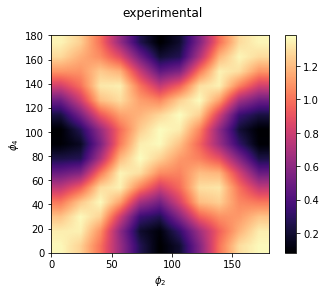

In [4]:
I_experimental=experimental_dict['intensities']
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental, title='experimental')

## Fitting to matrices: solo angulos


In [5]:
param_u0, u0 =get_light_parameters()
[amplitude, angle, phase]=param_u0
print(u0)

[[ 3.5431]
 [-0.0246]
 [ 0.0126]
 [ 3.5429]]


In [6]:
pol_dicts =get_polarimeter_parameters(kind='exp')
p1,p2,p3,p4=pol_dicts
pprint.pprint(pol_dicts)

[{'p0': 0.128068490426,
  'p1': 0.934950416021,
  'theta_axis': 0.048659779545601904},
 {'a': 1,
  'b': 1,
  'delta': 1.3854423602330987,
  'theta_axis': 0.7780084393445043},
 {'a': 1,
  'b': 1,
  'delta': 1.3854423602330987,
  'theta_axis': 2.2996981823052884},
 {'p0': 0.128068490426,
  'p1': 0.934950416021,
  'theta_axis': 2.8253389931284207}]


In [7]:
def get_intensity_numerical_angulos(par_fitting, angles_2, angles_3, u0):
    """
    par_fitting son los parámetros de optimización, en este caso
        angle_1, angle_2, angle_4, p1, p0, a, b, delta=par_fitting
    """
    
    angle_1_pol, angle_2_pol, angle_3_pol, angle_4_pol=par_fitting

    p0_best = 0.128068490426
    p1_best = 0.934950416021
    phase_best = 78.38*degrees
    
    P1=polarizer_linear(p1=p1_best, p2=p0_best, theta=0)
    P2=diattenuating_retarder(p1=1, p2=1, phase=phase_best, theta=angle_2_pol)
    P3=diattenuating_retarder(p1=1, p2=1, phase=phase_best, theta=angle_3_pol)
    P4=polarizer_linear(p1=p1_best, p2=p0_best, theta=angle_4_pol)
      
    Angles_2, Angles_3 = sp.meshgrid(angles_2, angles_3)
    intensity_numerical=sp.zeros_like(Angles_2, dtype=float)

    for i2, angle_2 in enumerate(angles_2):
        P2_r =rotate_mueller(P2, angle_2)
        for i3, angle_3 in enumerate(angles_3):
            P3_r =rotate_mueller(P3, angle_3)
            intensity_numerical[i3,i2]=intensity(P4*P3_r*P2_r*P1*u0)
            
    return intensity_numerical

In [8]:
def err_func3(par_error, angles_2, angles_3, u0,I_experimental):
    I_theory=get_intensity_numerical_angulos(par_error, angles_2, angles_3, u0)
    factor_intensidad=I_experimental.max()/I_theory.max()
    I_theory = I_theory*factor_intensidad

    return (abs(I_theory -I_experimental).flatten())

has_example=False
if has_example:
    params_3_ini=np.array([0*degrees, 45*degrees, 45*degrees, 90*degrees])
    error=err_func3(params_3_ini, angles_2_e, angles_3_e, u0,I_experimental)
    I_ini_3=get_intensity_numerical_angulos(params_3_ini, angles_2_e, 
                                       angles_3_e, u0)
    dibujar_2d_fitting(angles_2_e, angles_3_e, I_ini_3, 'inicial')
    print(error.mean())

In [9]:
params_3_ini=np.array([0*degrees, 45*degrees, 130*degrees,  0*degrees])
params_3_fin, success = optimize.leastsq(err_func3, params_3_ini,args=(angles_2_e, angles_3_e, u0, I_experimental))

In [10]:
print("""theta_1 = {:4.6}º, 
theta_2 = {:4.6}º, 
theta_3 = {:4.6}º, 
theta_4 = {:4.6}º""".format(params_3_fin[0]/degrees, 
                    params_3_fin[1]/degrees,params_3_fin[2]/degrees,params_3_fin[3]/degrees))

theta_1 =  0.0º, 
theta_2 = 43.6046º, 
theta_3 = 126.52º, 
theta_4 = -3.37835º


In [13]:
print(sp.remainder(params_3_fin, 2*sp.pi)/degrees)

[   0.       43.6046  126.5201  356.6216]


1.01230615845
0.0776404706007


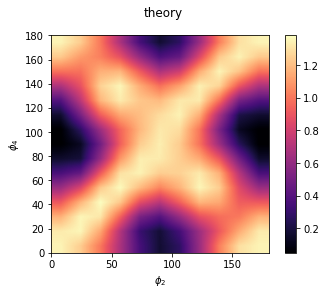

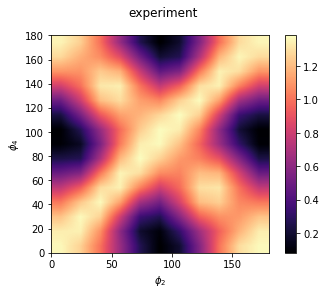

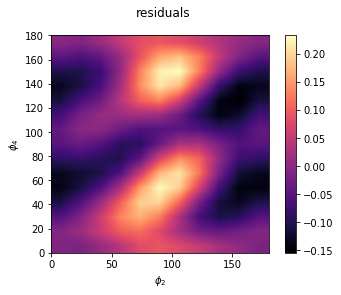

In [12]:
I_best3=get_intensity_numerical_angulos(params_3_fin, angles_2_e, 
                                       angles_3_e, u0)

factor_intensidad=I_experimental.max()/I_best3.max()
I_best3 = I_best3*factor_intensidad
residuals=I_best3-I_experimental

dibujar_2d_fitting(angles_2_e, angles_3_e, I_best3, 'theory')
dibujar_2d_fitting(angles_2_e, angles_3_e, I_experimental,'experiment')
dibujar_2d_fitting(angles_2_e, angles_3_e, residuals, 'residuals')
print(factor_intensidad)
print(sp.mean(abs(residuals)))